In [1]:

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
sys.path.insert(0, os.path.abspath('ComParE2022_VecNet/src'))

import config ,config_pytorch
#from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
# import IPython.display as ipd

# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.models import model_parameters
from glob import glob
## nnAudio
from nnAudio import features , Spectrogram
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import argparse
import wget
os.environ['TORCH_HOME'] = '../../pretrained_models'

from timm.models.layers import to_2tuple,trunc_normal_


/opt/conda/lib/python3.8/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [2]:
# Parse input arguments
#parser = argparse.ArgumentParser(description='Trainable_SpecAugment', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
batch_size =128
num_workers= 4
pin_memory = True
test_batch_size=128
DEBUG= False
num_epochs =200
USE_SHORT_AUDIO = True,
                



In [3]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]

In [4]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    #This is same as defined in config -min_duration = win_size * frame_duration
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    stride = step_frac*min_length
#     print("min_length = " +str(min_length))
#     print("step_frac = " +str(step_frac))
#     print("stride = " +str(stride))
    for _,row in df.iterrows():
        #processed_data keeps track of the tensor_values processed thus far
        if row['length'] > min_length:
            processed_data = 0
            #total_data is the total tensor present in the audio
            total_data = config.rate*row['length']
            #print("********")
            count = 0
            #print("count = " +str(count))
            #print("id = " + str(row['id']) + " duration = " +str(row['length']) + "total x vals = " + str(total_data))
            inner_loop_flag = False
            #print("going into the inner loop to offset....")
            while(processed_data < total_data):
                #print("inside inner loop.....")
                start = count*stride*config.rate
                #now find out the row_len
                if total_data - (start + min_length*config.rate) >= 0:
                    #print("full chunk ")
                    row_len = min_length
                    end = start + row_len*config.rate
                    audio_offsets.append({'id':row['id'], 'offset':count, 'length': row_len,'specie_ind': row['specie_ind'],'start':start,'end':end})
                    #print("count = " +str(count) + "offset = " +str(count) + "start = " +str(start) + "end = " +str(end))
                    #print("for count.... = " + str(count) + "processed data = " +str(processed_data))
                    count+=1
                    processed_data = (count*stride)*config.rate
                    
                else:
                    inner_loop_flag = True
                    break
                    
                                                       
            #for processing residual data
            if(inner_loop_flag):
                #print("processing residual ....processed " +str(processed_data) + " of " + str(total_data))
                start = count*stride*config.rate
                resid_durn = round((total_data - processed_data)/config.rate,2)
                end = total_data
                #print("for..." + str(row['id']) + " adding the residual data in the data frame with duration = " + str(resid_durn))
                audio_offsets.append({'id':row['id'], 'offset':count, 'length':resid_durn ,'specie_ind': row['specie_ind'],'start':start,'end':end})
            
        elif short_audio:
            start = 0
            end = row['length']*config.rate
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind'],'start':0 , 'end':end})
    return pd.DataFrame(audio_offsets)       


In [5]:

def prepare_df(classes ,csv_loc = config.data_df  ):
    """This function reads a csv and creates a dataframe for further processing."""
    df = pd.read_csv(csv_loc)
    #df = df.loc[df['Grade'].notnull()]
    df = df.loc[df['species'].notnull()]
    # a new column for specie_index to hold numerical values for specie
    df['specie_ind'] = "NULL_VAL"
    ind = 0
    for specie in classes:
        print("specie = " + str(specie) + "and its index = " + str(ind) )
        row_indexes=df[df['species']==specie].index 
        df.loc[row_indexes,'specie_ind']= ind
        ind+=1
    #remove all the rows where specie is other than the one present in classes
    df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
    #filter the data for TZ and cup recordings only
    idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
    df_all = df[idx_multiclass]
    df_all.reset_index(inplace=True, drop = True )
    return df_all


In [6]:
def plot_df(df):
    fig, ax = plt.subplots(figsize=(8, 6))
    import seaborn as sns
    sns.countplot(x = 'species', data = df , ax = ax , hue = 'gender',palette='dark')
    #ax.bar_label(ax.containers[0])
    #ax.bar_label(ax.containers[-1], fmt='Count:\n%.2f', label_type='center')
    plt.xticks(rotation=90 )
    plt.title("Distribution of Species ")
    plt.rc('xtick', labelsize=12)
    plt.rc('xtick', labelsize=12)
    plt.rc('axes', labelsize=15)
    plt.rc('figure', titlesize=15)
    plt.show

### Train _test split####
def train_test_split(df_all):
    np.random.seed(42)
    msk_test = np.random.rand(len(df_all)) < 0.2
    df_test = df_all[msk_test]
    df_train_temp  = df_all[~msk_test]
    msk_train = np.random.rand(len(df_train_temp)) < 0.2
    df_val = df_train_temp[msk_train]
    df_train  = df_train_temp[~msk_train]
    return df_train ,df_val ,df_test

### Validate split ####
def validate_split(df1 , df2):
    df_temp = pd.merge(df1,df2, on = 'id', how = 'inner')
    #print(df_temp)
    common_elem = len(df_temp)
    #print("common_elem = ",common_elem)
    con = (common_elem == 0)
    #print("condition = ",con)
    assert (con), "Split has issues"
    print("split is a success")

### Specie _distribution ###
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))

## Class weights to address imbalance in classes ###
def get_class_weights(df):
    np.array(df_train_offset.specie_ind)
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df.specie_ind)),y=np.array(np.array(df.specie_ind)))
    print(type(class_weights))
    print(class_weights.shape)
    return class_weights


In [7]:
# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

def get_sinusoid_encoding(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class ASTModel(nn.Module):
    def __init__(self, label_dim=527,
                 fshape=128, tshape=2, fstride=128, tstride=2,
                 input_fdim=128, input_tdim=1024, model_size='base',
                 pretrain_stage=True, load_pretrained_mdl_path=None):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # pretrain the AST models
        if pretrain_stage == True:
            if load_pretrained_mdl_path != None:
                raise ValueError('Setting load_pretrained_mdl_path at pretraining stage is useless, pretraining is always from scratch, please change it to None.')
            if fstride != fshape or tstride != tshape:
                raise ValueError('fstride != fshape or tstride != tshape, they must be same at the pretraining stage, patch split overlapping is not supported.')

            # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
            if model_size == 'tiny':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=False)
                self.heads, self.depth = 3, 12
                self.cls_token_num = 2
            elif model_size == 'small':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=False)
                self.heads, self.depth = 6, 12
                self.cls_token_num = 2
            elif model_size == 'base':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=False)
                self.heads, self.depth = 12, 12
                self.cls_token_num = 2
            elif model_size == 'base_nokd':
                self.v = timm.create_model('vit_deit_base_patch16_384', pretrained=False)
                self.heads, self.depth = 12, 12
                self.cls_token_num = 1
            else:
                raise Exception('Model size must be one of tiny, small, base, base_nokd')

            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]

            # SSL Pretraining Code
            self.softmax = nn.Softmax(dim=-1)
            self.lsoftmax = nn.LogSoftmax(dim=-1)
            self.fshape, self.tshape = fshape, tshape
            self.fstride, self.tstride = fstride, tstride
            self.input_fdim, self.input_tdim = input_fdim, input_tdim
            # this is a trick to make state_dict to track pretraining input_fdim and input_tdim and save them by using torch.save
            self.p_input_fdim, self.p_input_tdim = nn.Parameter(torch.tensor(input_fdim), requires_grad=False), nn.Parameter(torch.tensor(input_tdim), requires_grad=False)

            # masked patch classification (discriminative objective) layer
            # we use two layers for pretext task, but using a single layer has similar performance.
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            self.cpredlayer = nn.Sequential(nn.Linear(self.original_embedding_dim, self.original_embedding_dim), nn.ReLU(), nn.Linear(self.original_embedding_dim, 256))
            # masked patch reconstruction (generative objective) layer
            self.gpredlayer = nn.Sequential(nn.Linear(self.original_embedding_dim, self.original_embedding_dim), nn.ReLU(), nn.Linear(self.original_embedding_dim, 256))
            self.unfold = torch.nn.Unfold(kernel_size=(fshape, tshape), stride=(fstride, tstride))

            # we use learnable mask embedding (follow the BEIT paper), but using a fixed mask embedding (e.g., 0) leads to same performance.
            self.mask_embed = nn.Parameter(torch.zeros([1, 1, self.original_embedding_dim]))
            self.mask_embed = torch.nn.init.xavier_normal_(self.mask_embed)

            # get the intermediate shape
            self.p_f_dim, self.p_t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim, fshape, tshape)
            num_patches = self.p_f_dim * self.p_t_dim
            self.num_patches = num_patches
            self.v.patch_embed.num_patches = num_patches
            print('pretraining patch split stride: frequency={:d}, time={:d}'.format(fstride, tstride))
            print('pretraining patch shape: frequency={:d}, time={:d}'.format(fshape, tshape))
            print('pretraining patch array dimension: frequency={:d}, time={:d}'.format(self.p_f_dim, self.p_t_dim))
            print('pretraining number of patches={:d}'.format(num_patches))

            # the linear patch projection layer, use 1 channel for spectrogram rather than the original 3 channels for RGB images.
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
            self.v.patch_embed.proj = new_proj

            # use trainable positional embedding
            new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + self.cls_token_num, self.original_embedding_dim))
            self.v.pos_embed = new_pos_embed
            trunc_normal_(self.v.pos_embed, std=.02)

        # use a pretrained models for finetuning
        elif pretrain_stage == False:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if load_pretrained_mdl_path == None:
                raise ValueError('Please set load_pretrained_mdl_path to load a pretrained models.')
            sd = torch.load(load_pretrained_mdl_path, map_location=device)
            # get the fshape and tshape, input_fdim and input_tdim in the pretraining stage
            try:
                p_fshape, p_tshape = sd['module.v.patch_embed.proj.weight'].shape[2], sd['module.v.patch_embed.proj.weight'].shape[3]
                p_input_fdim, p_input_tdim = sd['module.p_input_fdim'].item(), sd['module.p_input_tdim'].item()
            except:
                raise  ValueError('The model loaded is not from a torch.nn.Dataparallel object. Wrap it with torch.nn.Dataparallel and try again.')

            print('now load a SSL pretrained models from ' + load_pretrained_mdl_path)
            # during pretraining, fstride=fshape and tstride=tshape because no patch overlapping is used
            # here, input_fdim and input_tdim should be that used in pretraining, not that in the fine-tuning.
            # we need to know input_fdim and input_tdim to do positional embedding cut/interpolation.
            # generally it should be better to use same input_fdim during pretraining and finetuning, but input_tdim can be safely different
            audio_model = ASTModel(fstride=p_fshape, tstride=p_tshape, fshape=p_fshape, tshape=p_tshape,
                                   input_fdim=p_input_fdim, input_tdim=p_input_tdim, pretrain_stage=True, model_size=model_size)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)

            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.cls_token_num = audio_model.module.cls_token_num

            # mlp head for fine-tuning
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                          nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim, fshape, tshape)
            # patch array dimension during pretraining
            p_f_dim, p_t_dim = audio_model.module.p_f_dim, audio_model.module.p_t_dim
            num_patches = f_dim * t_dim
            p_num_patches = p_f_dim * p_t_dim
            self.v.patch_embed.num_patches = num_patches
            print('fine-tuning patch split stride: frequncey={:d}, time={:d}'.format(fstride, tstride))
            print('fine-tuning number of patches={:d}'.format(num_patches))

            # patch shape should be same for pretraining and fine-tuning
            if fshape != p_fshape or tshape != p_tshape:
                raise ValueError('The patch shape of pretraining and fine-tuning is not consistant, pretraining: f={:d}, t={:d}, finetuning: f={:d}, t={:d}'.format(p_fshape, p_tshape, fshape, tshape))

            # patch split stride generally should be different for pretraining and fine-tuning, as patch split overlapping is only used in finetuning
            # during pretraining, p_fshape = p_fstride and p_tshape = p_tstride
            if fstride != p_fshape or tstride != p_tshape:
                # initialize a new patch embedding layer with desired new stride.
                new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
                # but the weights of patch embedding layer is still got from the pretrained models
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
                self.v.patch_embed.proj = new_proj

            new_pos_embed = self.v.pos_embed[:, self.cls_token_num:, :].detach().reshape(1, p_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, p_f_dim, p_t_dim)
            # cut or interpolate the positional embedding
            if t_dim < p_t_dim:
                new_pos_embed = new_pos_embed[:, :, :, int(p_t_dim/2) - int(t_dim / 2): int(p_t_dim/2) - int(t_dim / 2) + t_dim]
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(8, t_dim), mode='bilinear')
            if f_dim < p_f_dim:
                new_pos_embed = new_pos_embed[:, :, int(p_f_dim/2) - int(f_dim / 2): int(p_f_dim/2) - int(f_dim / 2) + t_dim, :]
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')

            new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :self.cls_token_num, :].detach(), new_pos_embed], dim=1))

    # get the shape of intermediate representation.
    def get_shape(self, fstride, tstride, input_fdim, input_tdim, fshape, tshape):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    # generate mask for 16*16 patch
    def gen_maskid_patch(self, sequence_len=512, mask_size=100, cluster=3):
        mask_id = []

        # randomize clutering factor in [3,6)
        cur_clus = randrange(cluster) + 3

        while len(list(set(mask_id))) <= mask_size:
            start_id = randrange(sequence_len)

            # this improves the efficiency, but might change the pretrained model
            # while start_id in mask_id:
            #     start_id = randrange(sequence_len)

            cur_mask = []
            for i in range(0, cur_clus):
                for j in range(0, cur_clus):
                    mask_cand = start_id + self.p_t_dim * i + j
                    if mask_cand > 0 and mask_cand < sequence_len:
                        cur_mask.append(mask_cand)
            mask_id = mask_id + cur_mask
        mask_id = list(set(mask_id))[:mask_size]
        return torch.tensor(mask_id)

    # using cluster for frame masking hurts the performance, so just use the naive random sampling
    def gen_maskid_frame(self, sequence_len=512, mask_size=100):
        mask_id = random.sample(range(0, sequence_len), mask_size)
        return torch.tensor(mask_id)

    def finetuningavgtok(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.mlp_head(x)
        return x

    def finetuningcls(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # if models has two cls tokens (DEIT), average as the clip-level representation
        if self.cls_token_num == 2:
            x = (x[:, 0] + x[:, 1]) / 2
        else:
            x = x[:, 0]
        x = self.mlp_head(x)
        return x

    # masked patch pretraining with discriminative objective
    def mpc(self, x, mask_patch, cluster, show_mask=False):
        input = self.unfold(x).transpose(1, 2)
        B = x.shape[0]
        # x in shape (batch_size, sequence_len, embedding dim)
        x = self.v.patch_embed(x)

        # encode the patch
        # size 12(batch_size) * 100(#mask_patch) * 768(hidden_dim), prepare to save the true values of masked samples
        encode_samples = torch.empty((B, mask_patch, 256), device=x.device, requires_grad=False).float()
        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)

        # for each audio clip in the batch
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            if cluster == True:
                # use this if you are masking e.g. 16*16 patches
                mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            else:
                # use this if you are masking frame, i.e., 128*2 patches
                mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            # copy the masked embeddings, note gradients are stopped in this path
            encode_samples[i] = input[i, mask_index[i], :].clone().detach()
            # mask the encode samples with 0
            mask_dense[i, mask_index[i], :] = 0

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # mask the patch
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # pass through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        # prediction of the masked patch
        pred = torch.empty((B, mask_patch, 256), device=x.device).float()  # e.g. size 12*100*768
        for i in range(B):
            #  +2 for indexes because skipping the cls and dis token
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            pred[i] = self.cpredlayer(x[i, mask_index[i] + self.cls_token_num, :])

        # calculate the NCE loss
        nce = torch.tensor(0.0).to(x.device)
        correct = torch.tensor(0.0).to(x.device)
        for i in np.arange(0, B):
            # negative samples are from the same batch
            # 8/12/2022: has a difference with equation (1) in the ssast paper but (likely) performance-wise similar, see https://github.com/YuanGongND/ssast/issues/13
            total = torch.mm(encode_samples[i], torch.transpose(pred[i], 0, 1))  # e.g. size 100*100
            correct += torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0), torch.arange(0, mask_patch, device=x.device)))  # correct is a tensor
            nce += torch.sum(torch.diag(self.lsoftmax(total)))  # nce is a tensor
        acc = 1. * correct / (B * mask_patch)
        nce = nce / (-1. * B * mask_patch)

        # visualize the masked area, for probing test only, set show_mask = False for any training/inference.
        if show_mask == False:
            return acc, nce
        else:
            if B > 1:
                raise Exception('Currently only support single spectrogram probing test.')

            self.mask_correct = torch.nn.Parameter(torch.arange(0, mask_patch), requires_grad=False)

            pred = input.clone()  # [B, 512, 256]
            masked = input.clone()

            for i in range(B):
                result = [float(t) * 99 for t in torch.eq(torch.argmax(self.softmax(total), dim=0), self.mask_correct)]
                pred[i, mask_index[i], :] = torch.tensor(result).reshape(mask_patch, 1).expand(mask_patch, 256)
                masked[i, mask_index[i], :] = 99.0

            # print(total)
            # print(self.softmax(total))
            # print(torch.argmax(self.softmax(total), dim=0))
            # print(self.mask_correct)
            # print(torch.eq(torch.argmax(self.softmax(total), dim=0), self.mask_correct))
            # print([float(t)*99 for t in torch.eq(torch.argmax(self.softmax(total), dim=0), self.mask_correct)])

            fold = torch.nn.Fold(output_size=([self.input_fdim, self.input_tdim]), kernel_size=(self.fshape, self.tshape), stride=(self.fstride, self.tstride))
            pred = fold(pred.transpose(1, 2))
            masked = fold(masked.transpose(1, 2))

            return pred, masked

    # # masked patch pretraining with generative objective
    def mpg(self, input, mask_patch, cluster):
        B = input.shape[0]
        x = self.v.patch_embed(input)
        input = self.unfold(input).transpose(1, 2)

        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            if cluster == True:
                # use this if you are masking e.g. 16*16 patches
                mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            else:
                # use this if you are masking frame, i.e., 128*2 patches
                mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            mask_dense[i, mask_index[i], :] = 0

        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # go through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        pred = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float()  # e.g. size 12*100*256
        target = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float() # e.g. size 12*100*256

        for i in range(B):
            #  +2 for indexes because cls and dis token
            pred[i] = self.gpredlayer(x[i, mask_index[i] + self.cls_token_num, :])
            target[i] = input[i, mask_index[i], :]

        # calculate the MSE loss
        mse = torch.mean((pred - target) ** 2)

        return mse

    def forward(self, x, task ='ft_avgtok' , cluster=True, mask_patch=400):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # finetuning (ft), use the mean of all token (patch) output as clip-level representation.
        # this is default for SSAST fine-tuning as during pretraining, supervision signal is given to each token, not the [cls] token
        if task == 'ft_avgtok':
            return self.finetuningavgtok(x)
        # alternatively, use the [cls] token output as clip-level representation.
        elif task == 'ft_cls':
            return self.finetuningcls(x)
        # pretraining, masked patch classification (discriminative objective)
        elif task == 'pretrain_mpc':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster)
        # pretraining, masked patch reconstruction (generative objective)
        elif task == 'pretrain_mpg':
            return self.mpg(x, mask_patch=mask_patch, cluster=cluster)
        elif task == 'visualize_mask':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster, show_mask=True)
        else:
            raise Exception('Task unrecognized.')


In [8]:
torch.tensor(2.6860e-05)
torch.tensor(0.0094)

tensor(0.0094)

In [9]:
class MyModel(nn.Module):
    def __init__(self, mean = torch.tensor(2.6860e-05), std = torch.tensor(0.0094)):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = ASTModel(label_dim=8,
             fshape=16, tshape=16, fstride=10, tstride=10,
             input_fdim=1025, input_tdim=31, model_size='base',
             pretrain_stage=False, load_pretrained_mdl_path="../../models/AST_pre/SSAST-Base-Patch-400.pth").to('cuda')
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        #self.out = nn.Linear(self.backbone.num_features, 1)
        self.mean = mean
        self.std = std
        #self.sizer = VT.Resize((image_size,image_size),antialias = True)
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=2*config.rate, output_format="Magnitude", trainable=True,verbose = False).to('cuda')
        self.batch_norm = nn.BatchNorm2d(num_features= 1)
        #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x,train = True):
        # first compute spectrogram
        spec_gram = self.spec_layer(x)
        #print("post spec gram shape = ",spec_gram.shape)
        #print("post norm shape = ",spec_gram.shape)
        spec_gram_nan_check = torch.isnan(spec_gram).any().item()
        assert not (spec_gram_nan_check) ,"Tensor contains NaN values after spec gram creation."
        
        with torch.no_grad():
            if train == True:
                #generate a random number and if condition is met apply aug
                ta_transformations_rndm_choice = VT.RandomChoice([AT.FrequencyMasking(freq_mask_param=100),AT.TimeMasking(time_mask_param=50)], p=[.05, .05])
                ta_transformations_rndm_apply = VT.RandomApply([AT.FrequencyMasking(freq_mask_param=50),AT.TimeMasking(time_mask_param=25)],p = .05)
                spec_gram = ta_transformations_rndm_choice(spec_gram)
                spec_gram = ta_transformations_rndm_apply(spec_gram)
                spec_gram_nan_check = torch.isnan(spec_gram).any().item()
                assert not (spec_gram_nan_check) ,"Tensor contains NaN values after augmentations  "
                
                
        #print("spec_gram shape = ",spec_gram.shape)    
        
        #x = self.sizer(spec_gram.squeeze(dim = 1))
        #print("post sizer shape = ",x.shape)
        #fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        x = (spec_gram - self.mean) / (self.std * 2)
        #print("post norm = ",x.shape)
        
        # then repeat channels
        del spec_gram,spec_gram_nan_check
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
                
        x = torch.transpose(x, 1, 2)
        x = self.backbone(x)
        backbone_op_nan_check = torch.isnan(x).any().item()
        assert not (backbone_op_nan_check) ,"Tensor contains NaN values in the backbone OP "
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred }
        #print(output)
        del x , backbone_op_nan_check
        return output


In [10]:
####### Prepare df######

#### plt df

### Pad_mean #####
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)


### Plot confusion Matrix ######
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()





    

# ### Model class ####
# Subclass the pretrained model and make it a binary classification
# Subclass the pretrained model and make it a binary classification

# Subclass the pretrained model and make it a binary classification



In [11]:
### Test Model####
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x,train = False)['prediction']
            #y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [12]:

## Train_model ####
#train_loader, val_loader, test_loader,model,classes,df_train_offset ,num_epochs = num_epochs 
def train_model(train_loader, val_loader,test_loader, model ,classes,class_weights,num_epochs ):
    # Creates a GradScaler once at the beginning of training.
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion_1 = nn.CrossEntropyLoss(weight=weights_adj,label_smoothing=.1)
    criterion_2 = nn.CrossEntropyLoss(weight=weights_adj)
    lr = .000015
    base_optimiser = timm.optim.AdamP(model.parameters(), lr= lr)
    look_optimiser = timm.optim.Lookahead(base_optimiser)
    cooldown_epoch = 50
    
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    #timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    scheduler = timm.scheduler.CosineLRScheduler(base_optimiser, t_initial= num_epochs,lr_min= lr/100,warmup_t = 5,warmup_lr_init= lr/10,noise_std=.075)
       
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    accumulation_steps = 4
    lr_log = []
    for e in range(num_epochs + cooldown_epoch):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 100 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            if DEBUG:
                print("inside train loop.. x device = " +str(x.device))
                
            
            y = inputs[1].type(torch.LongTensor).to(device)
            x_sum = torch.sum(x,axis = 1)
            x_sum.unsqueeze(dim = 1)
                                  
            with autocast():
                y_pred = model(x,train = True)['prediction']
                #y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred, axis = 1)
                if e < 20 :
                    
                    loss = criterion_1(y_pred, y)
                else:
                    
                    loss = criterion_2(y_pred, y)
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                   
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            loss.backward()
            all_y_pred.append(preds.cpu().detach())
            base_optimiser.step()
            base_optimiser.zero_grad()
            #scheduler.step(e)
                
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 1.0 )
            base_optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        look_optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            current_lr = base_optimiser.param_groups[0]['lr']
            print("Current LR = " + '{0:.8f}'.format(current_lr))
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        scheduler.step(e+1)
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1




In [13]:

#### Dataste class #####
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        temp_id = int(self.audio_df.loc[idx]['id'])
        file_path = os.path.join("..","..","data","audio")
        path_var = file_path +"/" +str(temp_id)+ str(".wav")
        entire_aud, inp_rate = torchaudio.load(path_var)
        if inp_rate != 2*config.rate:
            #print(" Original sample rate = " +str(inp_rate)+ " resampling ...")
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, 2*config.rate, dtype=entire_aud.dtype)
            entire_aud = resampler(entire_aud)
            #print("processsing file on " +str(path_var) + "Post resample shape =  " + str(entire_aud.shape))
        
        aud_len = self.audio_df.loc[idx]['length']
        offset = int(self.audio_df.loc[idx]['offset'])
        #print("sliced val = " +str(int((offset+config.min_duration)*config.rate)))
        start_pos = int(round(self.audio_df.loc[idx]['start']))
        #print("start_pos = " +str(start_pos))
        end_pos =  int(round(self.audio_df.loc[idx]['end']))
        #print("end_pos = " +str(end_pos))
        x = entire_aud[:,start_pos:end_pos]
        #print("extracted x = " +str(x))
        #print("x shape = " +str(x.shape))
        if aud_len < config.min_duration:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            #print("padding on " +str(path_var))
            f_out = pad_mean(x)
            #print("returning from padding  SHape = " +str(f_out.shape))
        else:
            f_out = x[0]
            f_out = f_out.unsqueeze(0)
            
        if DEBUG:
            print("idx = " + str(idx))
            #print("offset = " + str(offset))
            #print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(f_out.shape))
        
        #x_val = x[:,start:end]
        #now that we have final x- let's create specgram and add augmentations.
                 
        return (f_out,self.audio_df.loc[idx]['specie_ind'] )

In [14]:
### Get_indices ####
def get_indices(num_values ,df ,classes = classes):
    new_df = pd.DataFrame()
    for ind in range(len(classes)):
        #print("ind = ", ind)
        op = df[df['specie_ind'] == ind]
        #print("len op = ", len(op))
        op_new = op.sample(n = 1)
        #print("rand_ind = " , rand_ind)
        #([df1, df2], axis=1)
        new_df = pd.concat([op_new,new_df],axis = 0)
        #print("elem = " , elem)
        #new_list.append(elem)
    if len(new_df) < num_values:
        diff =  num_values - len(new_df)
        #print("diff = ", diff)
        remaining_elems= df.sample(n = diff)
        #print("len of remaining elems = ", len(remaining_elems))
        new_df = pd.concat([remaining_elems,new_df],axis = 0)
        
    #print("new_df = ", new_df)    
    new_df_1 = new_df.reset_index(drop = True)
    return new_df_1

#### Load model ####


In [15]:
def get_mean(loader):
    # set skip_norm as True only when you are computing the normalization stats
    #audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 24, 'timem': 192, 'mixup': 0.5, 'skip_norm': True, 'mode': 'train', 'dataset': 'audioset'}
    mean=[]
    std=[]
    for i, (audio_input, labels) in enumerate(loader):
        cur_mean = torch.mean(audio_input)
        cur_std = torch.std(audio_input)
        mean.append(cur_mean)
        std.append(cur_std)
        #print(cur_mean, cur_std)
    avg_mean = sum(mean)/len(mean)
    avg_std = sum(std)/len(std)
    #std_tensor = torch.cat(std)
    return avg_mean ,avg_std
#print(np.mean(mean), np.mean(std))

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7
now validating the split post loading and keeping TZ data
split is a success
split is a success
split is a success
now validating the split post offset_creation
split is a success
split is a success
split is a success
<class 'numpy.ndarray'>
(8,)
inside main. class_weigths type =  <class 'numpy.ndarray'>


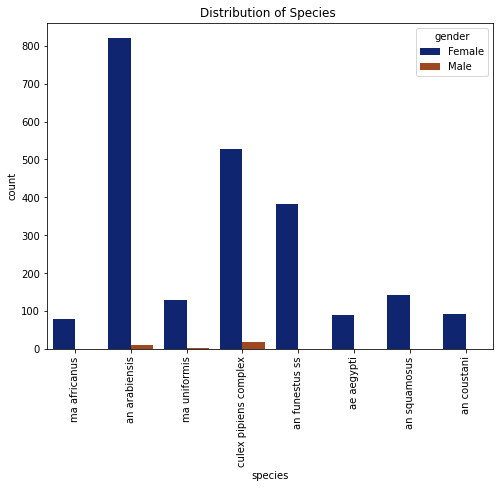

In [16]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
           'an coustani','ma uniformis','ma africanus' ]
csv_loc = os.path.join("..","..","data","metadata","neurips_2021_zenodo_0_0_1.csv")
df = prepare_df(classes = classes,csv_loc = csv_loc)
plot_df(df)
df_train ,df_val ,df_test = train_test_split(df)
print("now validating the split post loading and keeping TZ data")
validate_split(df_train ,df_val)
validate_split(df_train ,df_test)
validate_split(df_test ,df_val)
df_train_offset = get_offsets_df(df_train, short_audio=True)
df_test_offset = get_offsets_df(df_test, short_audio=True)
df_val_offset = get_offsets_df(df_val, short_audio=True)
df_train_offset.reset_index(inplace = True , drop = True)
df_test_offset.reset_index(inplace = True , drop = True)
df_val_offset.reset_index(inplace = True , drop = True)
print("now validating the split post offset_creation")
validate_split(df_train_offset ,df_val_offset)
validate_split(df_train_offset ,df_test_offset)
validate_split(df_test_offset ,df_val_offset)

class_weights = get_class_weights(df_train_offset)
print("inside main. class_weigths type = ", type(class_weights))

    

    


In [17]:
min_length = (config.win_size * config.n_hop) / config.rate

train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True, pin_memory=True )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory, shuffle = True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,shuffle = True)

In [18]:
#mean,std = get_mean(train_loader)

In [19]:
# print(mean)
# print(std)

now load a SSL pretrained models from ../../models/AST_pre/SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=202
Training on cuda:0
epoch = 0batch = 0 of 283duraation = 0.06745246251424154


/opt/conda/lib/python3.8/site-packages/timm/optim/adamp.py:84: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


epoch = 0batch = 100 of 283duraation = 1.830573817094167
epoch = 0batch = 200 of 283duraation = 3.5808250347773236
Epoch: 0, Train Loss: 2.41592805, Train f1: 0.04531393, Val Loss: 0.02564046, Val f1: 0.01797924, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e0_2023_05_28_17_07_51.pth
Now printing classification rport... 
********************************
Current LR = 0.00000150


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.75      0.00      0.00      4717
culex pipiens complex       0.33      0.00      0.00      2105
           ae aegypti       0.10      0.34      0.16       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.10      0.03      0.04       559
          an coustani       0.03      0.37      0.06       350
         ma uniformis       0.07      0.10      0.08       491
         ma africanus       0.04      0.73      0.07       223

             accuracy                           0.05     11043
            macro avg       0.18      0.20      0.05     11043
         weighted avg       0.40      0.05      0.02     11043

********************************


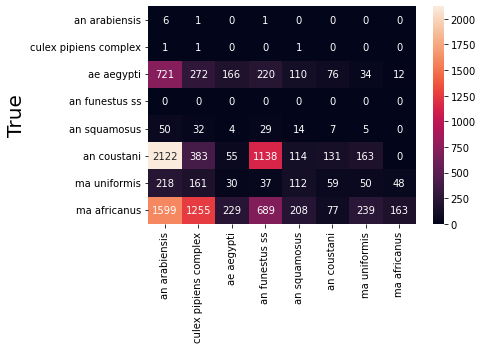

epoch = 1batch = 0 of 283duraation = 0.058067746957143146
epoch = 1batch = 100 of 283duraation = 1.8029712756474814
epoch = 1batch = 200 of 283duraation = 3.545889413356781
..Overrun....no improvement
Epoch: 1, Train Loss: 2.37837524, Train f1: 0.02083472, Val Loss: 0.02746309, Val f1: 0.01495326, overrun_counter 0
epoch = 2batch = 0 of 283duraation = 0.064080544312795
epoch = 2batch = 100 of 283duraation = 1.7982754667599996
epoch = 2batch = 200 of 283duraation = 3.5271794120470683
..Overrun....no improvement
Epoch: 2, Train Loss: 2.46483619, Train f1: 0.01951917, Val Loss: 0.03271152, Val f1: 0.01416774, overrun_counter 1
epoch = 3batch = 0 of 283duraation = 0.06156908671061198
epoch = 3batch = 100 of 283duraation = 1.8234368522961935
epoch = 3batch = 200 of 283duraation = 3.5662039518356323
..Overrun....no improvement
Epoch: 3, Train Loss: 2.50411711, Train f1: 0.01970892, Val Loss: 0.03373819, Val f1: 0.01782609, overrun_counter 2
epoch = 4batch = 0 of 283duraation = 0.060598878065

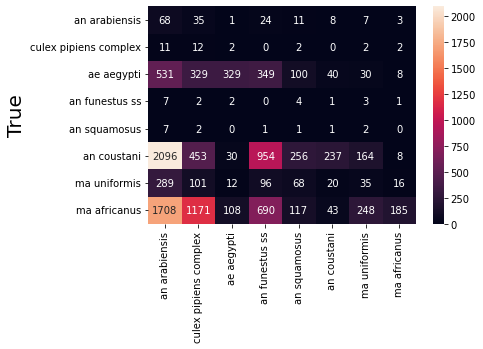

epoch = 22batch = 0 of 283duraation = 0.06521198352177938
epoch = 22batch = 100 of 283duraation = 1.8195582946141562
epoch = 22batch = 200 of 283duraation = 3.5314244190851847
Epoch: 22, Train Loss: 1.79612025, Train f1: 0.02366034, Val Loss: 0.02455927, Val f1: 0.02954938, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e22_2023_05_28_19_23_16.pth
Now printing classification rport... 
********************************
Current LR = 0.00001456
                       precision    recall  f1-score   support

        an arabiensis       0.40      0.01      0.02      4717
culex pipiens complex       0.22      0.01      0.01      2105
           ae aegypti       0.13      0.83      0.23       484
       an funestus ss       0.12      0.00      0.00      2114
         an squamosus       0.08      0.02      0.03       559
          an coustani       0.06      0.75      0.10       350
         ma uniformis       0.08      0.09      0.09       491
         ma african

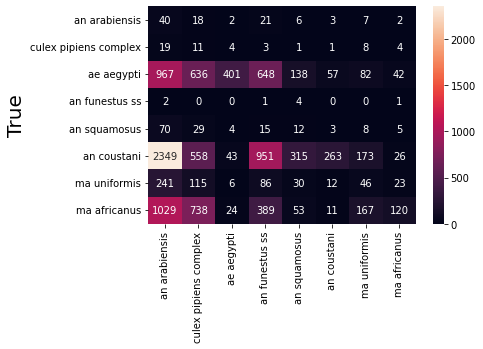

epoch = 23batch = 0 of 283duraation = 0.07016801436742147
epoch = 23batch = 100 of 283duraation = 1.8061374266942343
epoch = 23batch = 200 of 283duraation = 3.5548156539599103
Epoch: 23, Train Loss: 1.81569842, Train f1: 0.03139001, Val Loss: 0.02435921, Val f1: 0.02975507, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e23_2023_05_28_19_30_50.pth
Now printing classification rport... 
********************************
Current LR = 0.00001452


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.46      0.02      0.03      4717
culex pipiens complex       0.25      0.01      0.01      2105
           ae aegypti       0.22      0.62      0.32       484
       an funestus ss       0.10      0.00      0.00      2114
         an squamosus       0.21      0.01      0.01       559
          an coustani       0.06      0.64      0.11       350
         ma uniformis       0.00      0.00      0.00       491
         ma africanus       0.04      0.97      0.07       223

             accuracy                           0.08     11043
            macro avg       0.17      0.28      0.07     11043
         weighted avg       0.28      0.08      0.04     11043

********************************


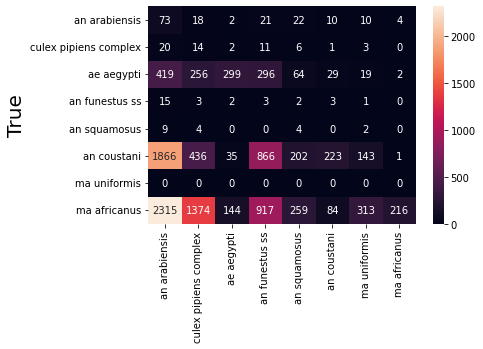

epoch = 24batch = 0 of 283duraation = 0.06880178054173787
epoch = 24batch = 100 of 283duraation = 1.8057725270589193
epoch = 24batch = 200 of 283duraation = 3.5440126498540243
Epoch: 24, Train Loss: 1.78499165, Train f1: 0.04664062, Val Loss: 0.02354677, Val f1: 0.05633207, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e24_2023_05_28_19_38_22.pth
Now printing classification rport... 
********************************
Current LR = 0.00001448
                       precision    recall  f1-score   support

        an arabiensis       0.48      0.04      0.07      4717
culex pipiens complex       0.21      0.01      0.02      2105
           ae aegypti       0.14      0.84      0.25       484
       an funestus ss       0.07      0.00      0.00      2114
         an squamosus       0.05      0.00      0.01       559
          an coustani       0.06      0.69      0.11       350
         ma uniformis       0.10      0.05      0.07       491
         ma african

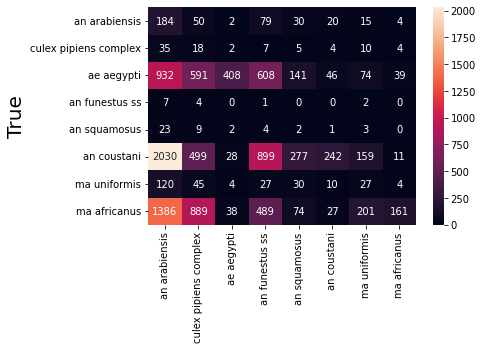

epoch = 25batch = 0 of 283duraation = 0.0657447894414266
epoch = 25batch = 100 of 283duraation = 1.7985011219978333
epoch = 25batch = 200 of 283duraation = 3.5481796781222026
..Overrun....no improvement
Epoch: 25, Train Loss: 1.80309896, Train f1: 0.04681228, Val Loss: 0.02372482, Val f1: 0.04860831, overrun_counter 0
epoch = 26batch = 0 of 283duraation = 0.0698150634765625
epoch = 26batch = 100 of 283duraation = 1.7794171094894409
epoch = 26batch = 200 of 283duraation = 3.5266257723172507
Epoch: 26, Train Loss: 1.80364010, Train f1: 0.04232302, Val Loss: 0.02302925, Val f1: 0.08976353, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e26_2023_05_28_19_51_55.pth
Now printing classification rport... 
********************************
Current LR = 0.00001439


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.49      0.10      0.16      4717
culex pipiens complex       0.18      0.01      0.02      2105
           ae aegypti       0.19      0.76      0.30       484
       an funestus ss       0.25      0.00      0.00      2114
         an squamosus       0.08      0.04      0.06       559
          an coustani       0.06      0.56      0.11       350
         ma uniformis       0.00      0.00      0.00       491
         ma africanus       0.04      0.88      0.08       223

             accuracy                           0.11     11043
            macro avg       0.16      0.29      0.09     11043
         weighted avg       0.31      0.11      0.09     11043

********************************


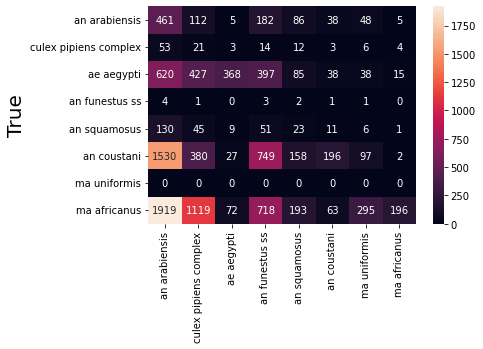

epoch = 27batch = 0 of 283duraation = 0.0720797856648763
epoch = 27batch = 100 of 283duraation = 1.8240870237350464
epoch = 27batch = 200 of 283duraation = 3.54034823179245
..Overrun....no improvement
Epoch: 27, Train Loss: 1.82362181, Train f1: 0.03869110, Val Loss: 0.02350270, Val f1: 0.02451080, overrun_counter 0
epoch = 28batch = 0 of 283duraation = 0.061078548431396484
epoch = 28batch = 100 of 283duraation = 1.8084641536076864
epoch = 28batch = 200 of 283duraation = 3.57478955189387
..Overrun....no improvement
Epoch: 28, Train Loss: 1.86879716, Train f1: 0.01968034, Val Loss: 0.02381508, Val f1: 0.01435330, overrun_counter 1
epoch = 29batch = 0 of 283duraation = 0.05929433902104696
epoch = 29batch = 100 of 283duraation = 1.7827767531077068
epoch = 29batch = 200 of 283duraation = 3.5302430351575214
..Overrun....no improvement
Epoch: 29, Train Loss: 1.87250016, Train f1: 0.01468645, Val Loss: 0.02365746, Val f1: 0.01457106, overrun_counter 2
epoch = 30batch = 0 of 283duraation = 0.0

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.48      0.11      0.17      4717
culex pipiens complex       0.20      0.01      0.02      2105
           ae aegypti       0.28      0.64      0.39       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.09      0.01      0.01       559
          an coustani       0.06      0.76      0.11       350
         ma uniformis       0.06      0.11      0.08       491
         ma africanus       0.05      0.77      0.10       223

             accuracy                           0.12     11043
            macro avg       0.15      0.30      0.11     11043
         weighted avg       0.26      0.12      0.10     11043

********************************


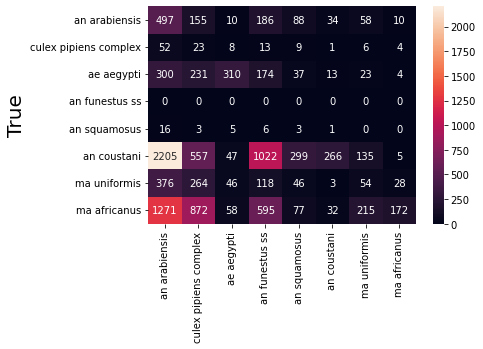

epoch = 69batch = 0 of 283duraation = 0.06089787483215332
epoch = 69batch = 100 of 283duraation = 1.7916674256324767
epoch = 69batch = 200 of 283duraation = 3.5474696278572084
Epoch: 69, Train Loss: 1.73473678, Train f1: 0.08274189, Val Loss: 0.02333859, Val f1: 0.10372816, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e69_2023_05_29_00_13_48.pth
Now printing classification rport... 
********************************
Current LR = 0.00001105


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.52      0.11      0.18      4717
culex pipiens complex       0.16      0.02      0.04      2105
           ae aegypti       0.21      0.75      0.33       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.07      0.01      0.01       559
          an coustani       0.07      0.67      0.12       350
         ma uniformis       0.07      0.24      0.11       491
         ma africanus       0.04      0.54      0.08       223

             accuracy                           0.13     11043
            macro avg       0.14      0.29      0.11     11043
         weighted avg       0.27      0.13      0.11     11043

********************************


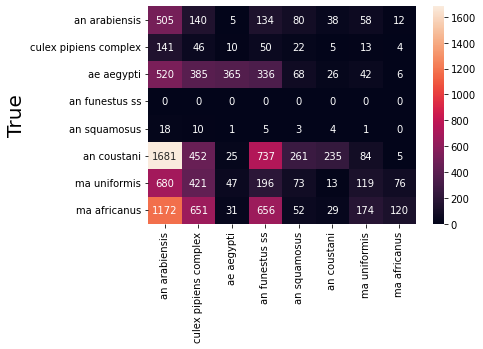

epoch = 70batch = 0 of 283duraation = 0.0657148003578186
epoch = 70batch = 100 of 283duraation = 1.813727037111918
epoch = 70batch = 200 of 283duraation = 3.5545897205670673
Epoch: 70, Train Loss: 1.72754908, Train f1: 0.08069306, Val Loss: 0.02291521, Val f1: 0.11470327, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e70_2023_05_29_00_21_24.pth
Now printing classification rport... 
********************************
Current LR = 0.00001095


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.49      0.12      0.19      4717
culex pipiens complex       0.16      0.02      0.03      2105
           ae aegypti       0.25      0.69      0.37       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.11      0.02      0.03       559
          an coustani       0.06      0.74      0.11       350
         ma uniformis       0.08      0.30      0.13       491
         ma africanus       0.05      0.51      0.09       223

             accuracy                           0.13     11043
            macro avg       0.15      0.30      0.12     11043
         weighted avg       0.26      0.13      0.12     11043

********************************


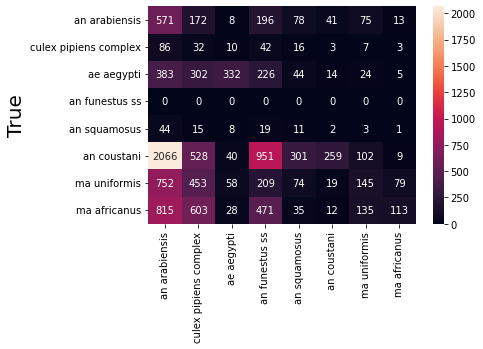

epoch = 71batch = 0 of 283duraation = 0.0644584854443868
epoch = 71batch = 100 of 283duraation = 1.8051697929700217
epoch = 71batch = 200 of 283duraation = 3.557936422030131
Epoch: 71, Train Loss: 1.72844982, Train f1: 0.09224280, Val Loss: 0.02300342, Val f1: 0.12686627, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e71_2023_05_29_00_28_59.pth
Now printing classification rport... 
********************************
Current LR = 0.00001084


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.50      0.13      0.21      4717
culex pipiens complex       0.16      0.03      0.05      2105
           ae aegypti       0.21      0.72      0.32       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.12      0.03      0.05       559
          an coustani       0.06      0.70      0.12       350
         ma uniformis       0.08      0.32      0.13       491
         ma africanus       0.05      0.41      0.09       223

             accuracy                           0.14     11043
            macro avg       0.15      0.29      0.12     11043
         weighted avg       0.26      0.14      0.13     11043

********************************


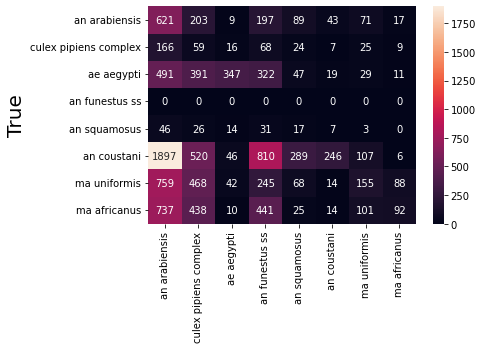

epoch = 72batch = 0 of 283duraation = 0.06597309509913127
epoch = 72batch = 100 of 283duraation = 1.7989970485369364
epoch = 72batch = 200 of 283duraation = 3.539284797509511
..Overrun....no improvement
Epoch: 72, Train Loss: 1.74013861, Train f1: 0.08968961, Val Loss: 0.02299618, Val f1: 0.12675594, overrun_counter 0
epoch = 73batch = 0 of 283duraation = 0.0654513676961263
epoch = 73batch = 100 of 283duraation = 1.797057278951009
epoch = 73batch = 200 of 283duraation = 3.5335984309514363
..Overrun....no improvement
Epoch: 73, Train Loss: 1.70869386, Train f1: 0.09959381, Val Loss: 0.02361137, Val f1: 0.11196345, overrun_counter 1
epoch = 74batch = 0 of 283duraation = 0.0692136287689209
epoch = 74batch = 100 of 283duraation = 1.841011901696523
epoch = 74batch = 200 of 283duraation = 3.5826637148857117
..Overrun....no improvement
Epoch: 74, Train Loss: 1.70549648, Train f1: 0.10017687, Val Loss: 0.02330058, Val f1: 0.11668911, overrun_counter 2
epoch = 75batch = 0 of 283duraation = 0.06

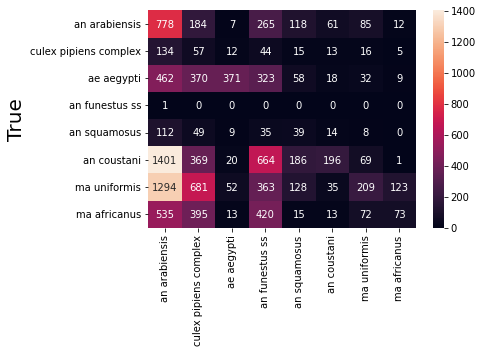

epoch = 78batch = 0 of 283duraation = 0.06026252905527751
epoch = 78batch = 100 of 283duraation = 1.8292100230852764
epoch = 78batch = 200 of 283duraation = 3.583499284585317
Epoch: 78, Train Loss: 1.70338680, Train f1: 0.09940228, Val Loss: 0.02272576, Val f1: 0.13670173, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e78_2023_05_29_01_14_18.pth
Now printing classification rport... 
********************************
Current LR = 0.00001009
                       precision    recall  f1-score   support

        an arabiensis       0.50      0.17      0.26      4717
culex pipiens complex       0.23      0.03      0.05      2105
           ae aegypti       0.26      0.71      0.38       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.07      0.03      0.04       559
          an coustani       0.06      0.65      0.11       350
         ma uniformis       0.08      0.33      0.12       491
         ma africanu

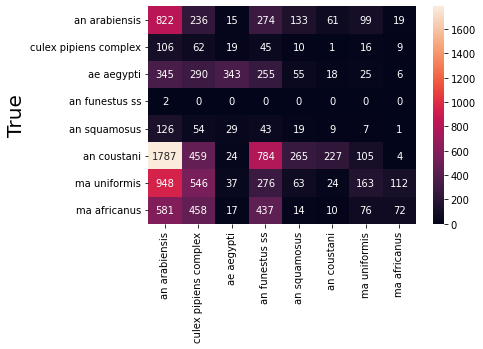

epoch = 79batch = 0 of 283duraation = 0.06433377663294475
epoch = 79batch = 100 of 283duraation = 1.85176393588384
epoch = 79batch = 200 of 283duraation = 3.5855382442474366
..Overrun....no improvement
Epoch: 79, Train Loss: 1.66846901, Train f1: 0.10685079, Val Loss: 0.02324570, Val f1: 0.13390837, overrun_counter 0
epoch = 80batch = 0 of 283duraation = 0.06806076765060425
epoch = 80batch = 100 of 283duraation = 1.7800258119901022
epoch = 80batch = 200 of 283duraation = 3.5503573258717855
..Overrun....no improvement
Epoch: 80, Train Loss: 1.67084354, Train f1: 0.10584156, Val Loss: 0.02355369, Val f1: 0.11806111, overrun_counter 1
epoch = 81batch = 0 of 283duraation = 0.06643606026967366
epoch = 81batch = 100 of 283duraation = 1.819274906317393
epoch = 81batch = 200 of 283duraation = 3.56805104414622
..Overrun....no improvement
Epoch: 81, Train Loss: 1.65956479, Train f1: 0.10783673, Val Loss: 0.02396346, Val f1: 0.10335183, overrun_counter 2
epoch = 82batch = 0 of 283duraation = 0.06

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.50      0.19      0.28      4717
culex pipiens complex       0.19      0.03      0.05      2105
           ae aegypti       0.31      0.66      0.42       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.11      0.07      0.09       559
          an coustani       0.06      0.59      0.11       350
         ma uniformis       0.08      0.36      0.13       491
         ma africanus       0.04      0.36      0.07       223

             accuracy                           0.16     11043
            macro avg       0.16      0.28      0.14     11043
         weighted avg       0.28      0.16      0.16     11043

********************************


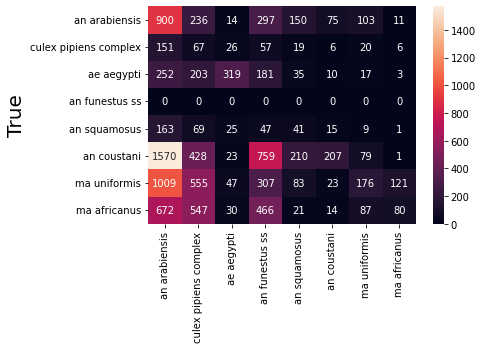

epoch = 89batch = 0 of 283duraation = 0.06782317161560059
epoch = 89batch = 100 of 283duraation = 1.8281901955604554
epoch = 89batch = 200 of 283duraation = 3.583418810367584
..Overrun....no improvement
Epoch: 89, Train Loss: 1.65382920, Train f1: 0.12986347, Val Loss: 0.02297462, Val f1: 0.15376807, overrun_counter 0
epoch = 90batch = 0 of 283duraation = 0.06839000781377157
epoch = 90batch = 100 of 283duraation = 1.835027798016866
epoch = 90batch = 200 of 283duraation = 3.5913637042045594
Epoch: 90, Train Loss: 1.65574574, Train f1: 0.12444044, Val Loss: 0.02263274, Val f1: 0.16536461, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e90_2023_05_29_02_29_47.pth
Now printing classification rport... 
********************************
Current LR = 0.00000874
                       precision    recall  f1-score   support

        an arabiensis       0.51      0.21      0.30      4717
culex pipiens complex       0.23      0.04      0.06      2105
           ae a

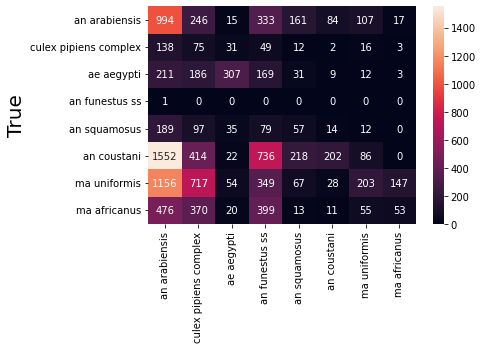

epoch = 91batch = 0 of 283duraation = 0.07158400217692057
epoch = 91batch = 100 of 283duraation = 1.820240080356598
epoch = 91batch = 200 of 283duraation = 3.549278219540914
..Overrun....no improvement
Epoch: 91, Train Loss: 1.66467798, Train f1: 0.12260756, Val Loss: 0.02316273, Val f1: 0.14333215, overrun_counter 0
epoch = 92batch = 0 of 283duraation = 0.06416657765706381
epoch = 92batch = 100 of 283duraation = 1.8198739091555278
epoch = 92batch = 200 of 283duraation = 3.5561252673467
..Overrun....no improvement
Epoch: 92, Train Loss: 1.66622899, Train f1: 0.13409010, Val Loss: 0.02314194, Val f1: 0.15330509, overrun_counter 1
epoch = 93batch = 0 of 283duraation = 0.06151498953501384
epoch = 93batch = 100 of 283duraation = 1.7979830702145894
epoch = 93batch = 200 of 283duraation = 3.5438812057177227
..Overrun....no improvement
Epoch: 93, Train Loss: 1.63345944, Train f1: 0.13443809, Val Loss: 0.02246633, Val f1: 0.16170827, overrun_counter 2
epoch = 94batch = 0 of 283duraation = 0.06

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.51      0.23      0.31      4717
culex pipiens complex       0.25      0.04      0.07      2105
           ae aegypti       0.34      0.68      0.45       484
       an funestus ss       0.00      0.00      0.00      2114
         an squamosus       0.12      0.16      0.14       559
          an coustani       0.07      0.55      0.12       350
         ma uniformis       0.08      0.43      0.13       491
         ma africanus       0.04      0.23      0.07       223

             accuracy                           0.18     11043
            macro avg       0.18      0.29      0.16     11043
         weighted avg       0.29      0.18      0.18     11043

********************************


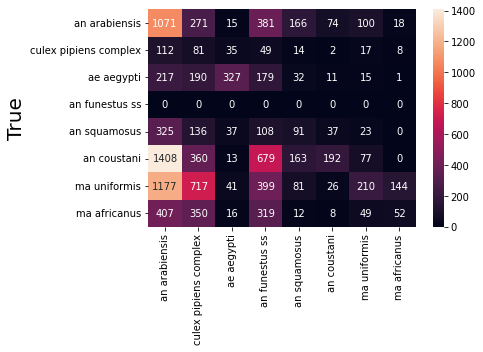

epoch = 95batch = 0 of 283duraation = 0.06591739257176717
epoch = 95batch = 100 of 283duraation = 1.7971363504727682
epoch = 95batch = 200 of 283duraation = 3.5478243152300517
..Overrun....no improvement
Epoch: 95, Train Loss: 1.63444938, Train f1: 0.14540205, Val Loss: 0.02282080, Val f1: 0.14910620, overrun_counter 0
epoch = 96batch = 0 of 283duraation = 0.06260483662287394
epoch = 96batch = 100 of 283duraation = 1.8308428446451823
epoch = 96batch = 200 of 283duraation = 3.576328682899475
..Overrun....no improvement
Epoch: 96, Train Loss: 1.64608957, Train f1: 0.13177836, Val Loss: 0.02281660, Val f1: 0.15682738, overrun_counter 1
epoch = 97batch = 0 of 283duraation = 0.07442143360773722
epoch = 97batch = 100 of 283duraation = 1.8163033564885458
epoch = 97batch = 200 of 283duraation = 3.569011874993642
..Overrun....no improvement
Epoch: 97, Train Loss: 1.66735948, Train f1: 0.12716566, Val Loss: 0.02284291, Val f1: 0.14865860, overrun_counter 2
epoch = 98batch = 0 of 283duraation = 0

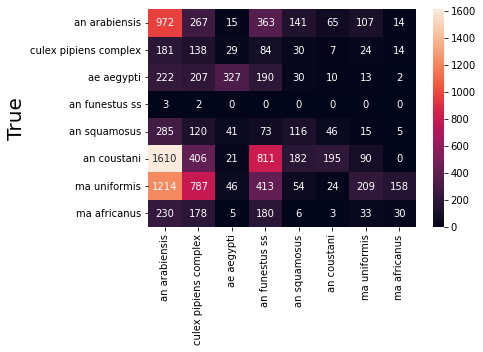

epoch = 127batch = 0 of 283duraation = 0.06897838513056437
epoch = 127batch = 100 of 283duraation = 1.792683211962382
epoch = 127batch = 200 of 283duraation = 3.560511855284373
..Overrun....no improvement
Epoch: 127, Train Loss: 1.55494830, Train f1: 0.15355607, Val Loss: 0.02332993, Val f1: 0.14271752, overrun_counter 0
epoch = 128batch = 0 of 283duraation = 0.06406642993291219
epoch = 128batch = 100 of 283duraation = 1.8154540459314983
epoch = 128batch = 200 of 283duraation = 3.543711268901825
..Overrun....no improvement
Epoch: 128, Train Loss: 1.60368579, Train f1: 0.12870271, Val Loss: 0.02272899, Val f1: 0.15427293, overrun_counter 1
epoch = 129batch = 0 of 283duraation = 0.07204272349675496
epoch = 129batch = 100 of 283duraation = 1.8075395782788595
epoch = 129batch = 200 of 283duraation = 3.544135348002116
..Overrun....no improvement
Epoch: 129, Train Loss: 1.63716361, Train f1: 0.13837403, Val Loss: 0.02296753, Val f1: 0.15548765, overrun_counter 2
epoch = 130batch = 0 of 283du

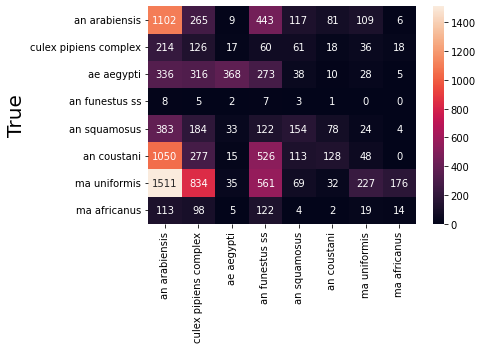

epoch = 212batch = 0 of 283duraation = 0.06226366360982259
epoch = 212batch = 100 of 283duraation = 1.8042160868644714
epoch = 212batch = 200 of 283duraation = 3.5693668405214947
..Overrun....no improvement
Epoch: 212, Train Loss: 1.61520112, Train f1: 0.13228112, Val Loss: 0.02386284, Val f1: 0.13947232, overrun_counter 0
epoch = 213batch = 0 of 283duraation = 0.06764736970265707
epoch = 213batch = 100 of 283duraation = 1.8357009609540305
epoch = 213batch = 200 of 283duraation = 3.5797537684440615
..Overrun....no improvement
Epoch: 213, Train Loss: 1.63475501, Train f1: 0.13488940, Val Loss: 0.02300315, Val f1: 0.15928540, overrun_counter 1
epoch = 214batch = 0 of 283duraation = 0.060681076844533284
epoch = 214batch = 100 of 283duraation = 1.7826476256052652
epoch = 214batch = 200 of 283duraation = 3.5442049503326416
..Overrun....no improvement
Epoch: 214, Train Loss: 1.60856173, Train f1: 0.14009740, Val Loss: 0.02358215, Val f1: 0.14024733, overrun_counter 2
epoch = 215batch = 0 of 

In [ ]:
model =MyModel()




#train_loader, val_loader,test_loader, model ,class_weights, classes = classes, num_epochs = args.num_epochs ,n_channels = 1
#train_loader, val_loader,test_loader, model, classes ,df,num_epochs = args.num_epochs ,n_channels = 1
tr_model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model,classes,class_weights ,num_epochs = num_epochs )

print("ALL DONE!!!!")


# def load_model(filepath, model=MyModel('convnext_xlarge_in22k')):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model